# Porod subtraction
Author: Eike Gericke \
Scattering curves of particles with sharp interfaces obey to the Porod law for high q-values. \
This means, the scattering intensity decreases proportional to an exponent -a- \
The Exponent -a- is equal -4 for spherical particles and -3 for flat particles. \
The coefficiant -c4- (I(q) = c4 * q^a) is proportional to the inner surface of the scattering structures. 
An additional angle (q-value) independent scattering contribution -c0- is related to e.g. Raman scattering or fluoreszense. \
\
The values -c0- and -c4- can be determiend using this sctipt.\
Knowing the values -c0- is nessesary to later determine the resonant scattering contribution in ASAXS experiments.\

## Libraries

In [3]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

## Job Parameters

In [24]:
# give the metadada directory
data_dir = 'Example_ASAXS'

# give the target file tyle:
target_file_type = 'Norm.dat'

porodFitting = True
plotFitResults = True

# Fitting limits
# for high q regime - using porod like fitting
q_pe_min = 2.0
q_pe_max = 7.0
q_pe_skipPoints = 30 # points to skip at the end indipendent from the actual q-range

# Fit Funktions
c0_start = 0.03
c1_start = 0.003
c4_start = 0.002
a_fix = 4
def porod_ext(x, c0, c1, c4):
    return c0 + c1 * x + c4 * x**(-a_fix)

## Job
### Search the directory

In [25]:
# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith(target_file_type) and entry.is_file():
        fileList.append(entry.path)

fileIterator = iter(fileList)
dF=pd.DataFrame()
for element in fileIterator: 
    dF = dF.append({'FileName':element.split(os.sep)[-1]},ignore_index=True)

Example_ASAXS\214neu_10000_eV_Tif_510_Norm.dat
Optimization range used is: 1.996949762316401  to  6.992165860334873  nm-1 between Index  90  and  338
Example_ASAXS\214neu_7000_eV_Tif_384_Norm.dat
Optimization range used is: 2.0041415644057814  to  5.331604217514716  nm-1 between Index  133  and  369
Example_ASAXS\214neu_8004_eV_Tif_402_Norm.dat
Optimization range used is: 2.001400482063151  to  6.096302346837033  nm-1 between Index  115  and  369
Example_ASAXS\214neu_8239_eV_Tif_420_Norm.dat
Optimization range used is: 1.9937800001151547  to  6.275284660881027  nm-1 between Index  111  and  369
Example_ASAXS\214neu_8304_eV_Tif_438_Norm.dat
Optimization range used is: 1.9927836053952475  to  6.324792182231029  nm-1 between Index  110  and  369
Example_ASAXS\214neu_8324_eV_Tif_456_Norm.dat
Optimization range used is: 1.9975833275954686  to  6.3400258073857225  nm-1 between Index  110  and  369
Example_ASAXS\214neu_8330_eV_Tif_474_Norm.dat
Optimization range used is: 1.9990243355102713  t

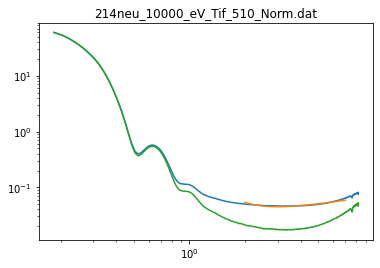

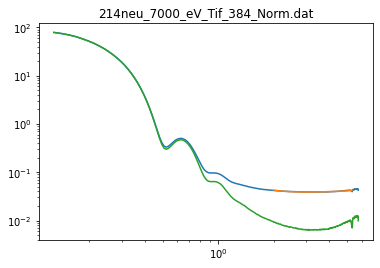

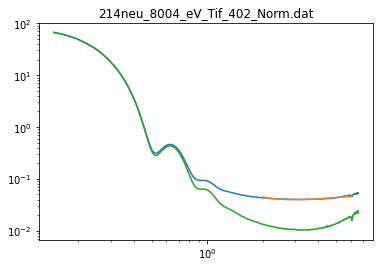

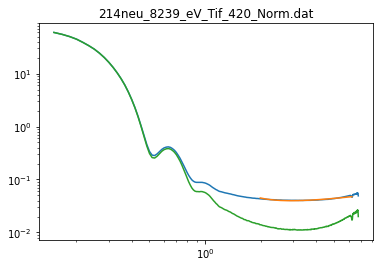

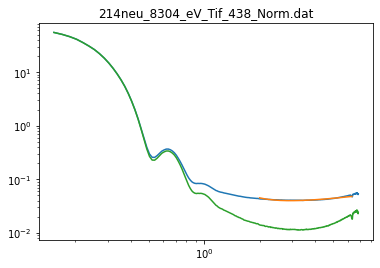

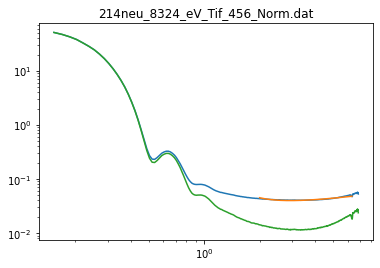

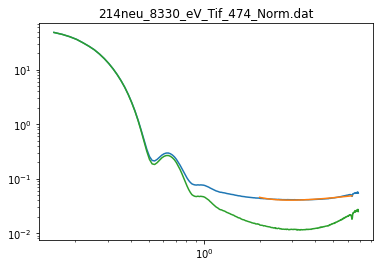

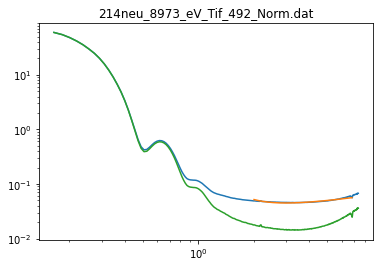

In [26]:
# make an path iterator from the found files
fileIterator = iter(fileList)
dF_pe=pd.DataFrame()

for element in fileIterator:
    q, I, e = np.genfromtxt(element,skip_header=0,unpack=True)
    print(element)
    
    if porodFitting == True: 
        # Define Fitting range
        q_shop = q[:-q_pe_skipPoints]
        q_pe_IndexMin = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_min))
        q_pe_IndexMax = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_max))
        print('Optimization range used is:',q[q_pe_IndexMin],' to ',q[q_pe_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        popt, pcov =optimize.curve_fit(porod_ext,q[q_pe_IndexMin:q_pe_IndexMax],I[q_pe_IndexMin:q_pe_IndexMax],p0=[c0_start,c1_start,c4_start],sigma=e[q_pe_IndexMin:q_pe_IndexMax])
        # Output Data
        dF_pe = dF_pe.append({'Porod_qMin':q[q_pe_IndexMin],'Porod_qMax':q[q_pe_IndexMax],'c0':popt[0],'c1':popt[1],'c4':popt[2]},ignore_index=True)
        #dF = dF.append(dF_pe)
        # Plotting the result
        if plotFitResults == True:
            I_gen = porod_ext(q[q_pe_IndexMin:q_pe_IndexMax],popt[0], popt[1], popt[2])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q[q_pe_IndexMin:q_pe_IndexMax], porod_ext(q[q_pe_IndexMin:q_pe_IndexMax],popt[0], popt[1], popt[2]))
            ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
        I_out=I-popt[0]
        
    
    # Save Numpy array to csv with header    
    save_file_name = element[:-4]+'_c0_Sub'+'.dat'
    file_header = str(element.split(os.sep)[-1])+'\tc0_Subtracted c0=\t'+str(popt[0])+'\n'+'q\tI\tPoisson error\nnm-1\tcm-1\tcm-1'
    np.savetxt(save_file_name, np.column_stack((q, I_out, e)), delimiter='\t', header=file_header)

# Save Pandas Frame to csv with header    
outputFrame = pd.concat([dF,dF_pe],axis=1)
save_outPut_name = data_dir+os.sep+'Porod_logg'+'.txt'
outputFrame.to_csv(save_outPut_name, sep='\t')

In [27]:
outputFrame

,FileName,Porod_qMax,Porod_qMin,c0,c1,c4
0,214neu_10000_eV_Tif_510_Norm.dat,6.992166,1.996950,0.028735,0.004291,0.258780
1,214neu_7000_eV_Tif_384_Norm.dat,5.331604,2.004142,0.032553,0.001672,0.106828
2,214neu_8004_eV_Tif_402_Norm.dat,6.096302,2.001400,0.029771,0.002714,0.150543
3,214neu_8239_eV_Tif_420_Norm.dat,6.275285,1.993780,0.029148,0.002901,0.156054
4,214neu_8304_eV_Tif_438_Norm.dat,6.324792,1.992784,0.029096,0.002974,0.158611
5,214neu_8324_eV_Tif_456_Norm.dat,6.340026,1.997583,0.028987,0.002983,0.160123
6,214neu_8330_eV_Tif_474_Norm.dat,6.344599,1.999024,0.029399,0.003008,0.160923
7,214neu_8973_eV_Tif_492_Norm.dat,6.834364,2.008749,0.031288,0.003632,0.215423
